## Data preparation with PANDAS

In [65]:
import pandas as pd


# Power plant conditions
p_conditions = pd.DataFrame({"Power plant":           ["Ahlen", "Fjället",  "Forsen",   "Kärret"],
                           "Initial reservoir level": [5800e6,  1000e6,     20e6,       13e6    ],
                           "Maximum reservoir level": [7160e6,  1675e6,     27e6,       13e6    ],
                           "Minimum reservoir level": [5800e6,  1000e6,     10e6,       6e6     ],
                           "Discharge capacity":      [540,     135,        975,        680     ],
                           "Power conversion":        [0.52,    1.17,       0.29,       0.05    ],
                           "Maximum spillage":        [820,     930,        360,        400     ],
                           "Local flow":              [177,     28,         8,          29      ],
                          })

# Time conditions
t_conditions = pd.DataFrame({"Time": range(1,13),
                             "Cost": [45, 55, 95, 80, 140, 150, 80, 70, 130, 0, 0, 0]})

# Flow conditions (Connections between the power plants)
f_conditions = pd.DataFrame({"From": ["Ahlen",  "Fjället",  "Forsen"],
                             "To":   ["Forsen", "Forsen",   "Kärret"],
                             "Time": [3,        2,          2]
                            })


## GAMSPy FTW

### Initializing all our Parameters and Varaibales etc

In [66]:

from gamspy import Container, Set, Variable, Parameter, Equation, Sum, Model, Sense, Alias


m = Container()

t = Set(m, name="t", description="time in hours", records=t_conditions['Time']) # time at begining of hour 1, 2, 3, ...
p = Set(m, name="p", description="Power plant", records=p_conditions['Power plant'])

# Create alias for set p
p_up = Alias(m, name="p_up", alias_with=p)

# Parameter and Variables definitions


delay = Parameter(m, name="delay", domain=[p,p], description="Time delay for upstream plants", records=f_conditions[['From', 'To', 'Time']])

prices = Parameter(m, name="prices", domain=t, description="Prices (MWh) at different hours", records=t_conditions[['Time', 'Cost']])

reservoir_init = Parameter(m, name="reservoir_init", domain=p, description="Initial reservoir level", records=p_conditions[['Power plant', 'Initial reservoir level']])
reservoir_max = Parameter(m, name="reservoir_max", domain=p, description="Maximum reservoir level", records=p_conditions[['Power plant', 'Maximum reservoir level']])
reservoir_min = Parameter(m, name="reservoir_min", domain=p, description="Minimum reservoir level", records=p_conditions[['Power plant', 'Minimum reservoir level']])
discharge_max = Parameter(m, name="discharge_max", domain=p, description="Discharge capacity", records=p_conditions[['Power plant', 'Discharge capacity']])
power_conversion = Parameter(m, name="power_conversion", domain=p, description="Power conversion", records=p_conditions[['Power plant', 'Power conversion']])
spillage_max = Parameter(m, name="spillage_max", domain=p, description="Maximum spillage", records=p_conditions[['Power plant', 'Maximum spillage']])
local_flow = Parameter(m, name="local_flow", domain=p, description="Local flow", records=p_conditions[['Power plant', 'Local flow']])

discharge = Variable(m, name="discharge", type="positive", domain=[t,p], description="Discharge rate at each power plant at each time")
spillage = Variable(m, name="spillage", type="positive", domain=[t,p], description="Spillage rate at each power plant at each time")
reservoir_level = Variable(m, name="reservoir_level", domain=[t,p], description="Reservoir level at each power plant at each time")
potential_volume = Variable(m, name="potential_volume", domain=p, description="Potential volume at each power plant at last time (T=10)")

### Equations and condtions

In [67]:
# Discharge criteria
discharge.up[t,p] = discharge_max[p]

# Spillage criteria
spillage.up[t,p] = spillage_max[p]

# Reservoir level criteria
reservoir_level.lo[t,p].where[t.ord > 1] = reservoir_min[p]
reservoir_level.up[t,p].where[t.ord > 1] = reservoir_max[p]
reservoir_level.fx[t,p].where[t.first] = reservoir_init[p] # Initial reservoir level should be set to reservoir initial level

# Potential volume criteria
potential = Equation(m, name="potential", domain=p, description="Potential volume at each power plant based on the volume at last time (T=10) and power plant above")
potential[p] = potential_volume[p] == Sum(p_up.where[delay[p_up,p]>0], potential_volume[p_up]) + reservoir_level["10",p] - reservoir_min[p]

# Single reservoir equation for all plants
reservoirs = Equation(m, name="reservoirs", domain=[t,p], description="Reservoir level at power plant (p) at different hours (t)")
reservoirs[t,p].where[t.ord > 1] = reservoir_level[t,p] == reservoir_level[t.lag(1),p] + 3600 * (
        # Upstream inflows
        Sum(p_up.where[delay[p_up,p]>0], 
            discharge[t.lag(delay[p_up, p]), p_up] + spillage[t.lag(delay[p_up, p]), p_up]
        )

        # Local inflow
        + local_flow[p]

        # Outflows
        - discharge[t.lag(1),p]
        - spillage[t.lag(1),p]
    )

### Obejctive

In [68]:
obj = Sum((t, p), prices[t]*power_conversion[p]*discharge[t,p]) + Sum(p, 95/3600*power_conversion[p]*potential_volume[p])

## Solution

In [69]:
flow = Model(m, name="flow", equations=m.getEquations(), objective=obj, problem="LP", sense=Sense.MAX)
flow.solve(solver="CPLEX")

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,345567.783333329,49,141,LP,CPLEX,0.002


## Optimization

In [70]:
flow.objective_value

345567.78333332855

In [87]:
import numpy as np
ns = np.linspace(0, 250, 251)

fs = np.zeros(len(ns))
vs = np.zeros(len(ns))
for i, n in enumerate(ns):
    obj = Sum((t, p), prices[t]*power_conversion[p]*discharge[t,p]) + Sum(p, n/3600*power_conversion[p]*potential_volume[p])
    flow = Model(m, name="flow", equations=m.getEquations(), objective=obj, problem="LP", sense=Sense.MAX)
    flow.solve(solver="CPLEX")
    fs[i] = flow.objective_value
    vs[i] = sum(potential_volume.records['level'])


In [88]:
derivative = fs[1:len(ns)-1]-fs[:len(ns)-2]
p_low = sum(derivative==0) # price before excess volume starts to matter
p_high = max(ns)-sum(derivative>2816) # price after excess volume starts to matter


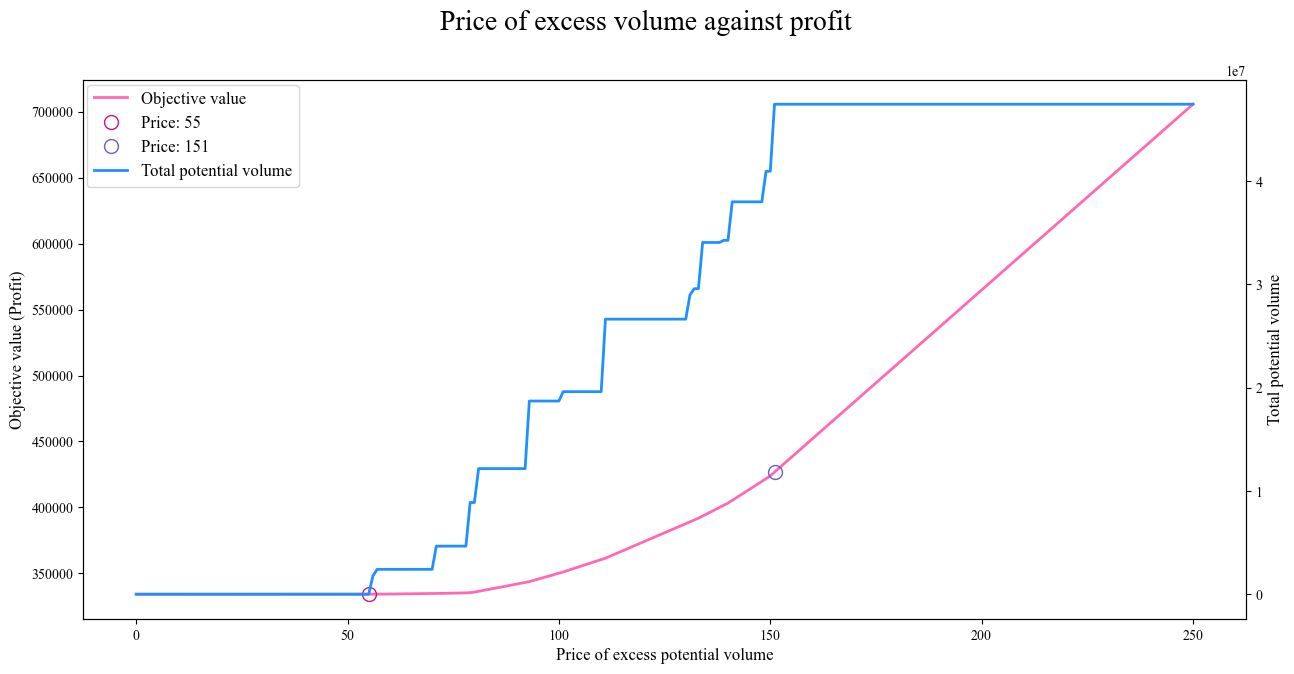

In [118]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

fig, ax1 = plt.subplots(figsize=(15, 7))
ax2 = ax1.twinx()
ax1.plot(ns, fs, color="hotpink", linewidth=2, label="Objective value")
ax2.plot(ns, vs, color="dodgerblue", linewidth=2, label="Total potential volume")
ax2.set_ylabel("Total potential volume", fontsize=12)
ax1.set_xlabel("Price of excess potential volume", fontsize=12)
ax1.set_ylabel("Objective value (Profit)", fontsize=12)
plt.suptitle("Price of excess volume against profit", fontsize=20)

ax1.plot(p_low, fs[p_low], 'o', color='mediumvioletred', markersize=10, markerfacecolor='none', label=f"Price: {p_low}")
ax1.plot(p_high, fs[int(p_high)], 'o', color='slateblue', markersize=10, markerfacecolor='none', label=f"Price: {int(p_high)}")
fig.legend(fontsize=12, bbox_to_anchor=(0.274, 0.885))


In [74]:
from IPython.display import HTML

def horizontal(dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 32px">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

### Primals Discharge, Spillage, Reservoir Level

In [75]:
# Convert levels to pandas DataFrames for easier handling
discharge_primal_df = pd.DataFrame(discharge.l.records).pivot(index='t', columns='p', values='level')
spillage_primal_df = pd.DataFrame(spillage.l.records).pivot(index='t', columns='p', values='level')
reservoir_level_primal_df = pd.DataFrame(reservoir_level.l.records).pivot(index='t', columns='p', values='level')

horizontal([discharge_primal_df, spillage_primal_df, reservoir_level_primal_df])

p,Ahlen,Fjället,Forsen,Kärret
t,,,,
1,0.0,0.0,0.0,29.0
2,0.0,0.0,0.0,29.0
3,0.0,0.0,0.0,58.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,29.0
6,0.0,0.0,0.0,116.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


### Duals Discharge, Spillage, Reservoir Level

In [76]:
# Convert marginals to pandas DataFrames for easier handling
discharge_duals_df = pd.DataFrame(discharge.m.records).pivot(index='t', columns='p', values='marginal')
spillage_duals_df = pd.DataFrame(spillage.m.records).pivot(index='t', columns='p', values='marginal')
reservoir_level_duals_df = pd.DataFrame(reservoir_level.m.records).pivot(index='t', columns='p', values='marginal')

horizontal([discharge_duals_df, spillage_duals_df, reservoir_level_duals_df])



p,Ahlen,Fjället,Forsen,Kärret
t,,,,
1,-106.6,-239.85,-69.2,0.00
2,-101.4,-228.15,-64.3,0.00
3,-80.6,-181.35,-52.7,0.00
4,-88.4,-198.90,-54.8,-0.75
5,-57.2,-128.70,-36.9,0.00
6,-52.0,-117.00,-34.0,0.00
7,-88.4,-198.90,-54.3,-3.50
8,-178.6,-210.60,-57.2,-4.00
9,-147.4,-225.40,-47.3,-1.00


## Extra

In [77]:
potential_volume.records

,p,level,marginal,lower,upper,scale
0,Ahlen,5734800.0,0.0,-inf,inf,1.0
1,Fjället,907200.0,0.0,-inf,inf,1.0
2,Forsen,16901200.0,0.0,-inf,inf,1.0
3,Kärret,23901200.0,0.0,-inf,inf,1.0
